## Load data

In [1]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, Normalize, rgb2gray
set_seed_torch(3)

In [28]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_1D_B1F515581A0A478A92AF1C58D4345408.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("visualpusher"),
 'device': 'cuda:0',
 'n_examples': 10,
 'n_predictions': 28,
})

In [29]:
with open(args.dataset_path, 'rb') as f:
    data = pkl.load(f)

imgs_rgb = torch.from_numpy(data["img"]).to(device=args.device).float()
imgs_gray = torch.from_numpy(rgb2gray(data["img"]).transpose(0, 1, 4, 2, 3)).to(device=args.device).float()
actions = torch.from_numpy(data["action"]).to(device=args.device).float()

## Visualize

In [30]:
from utils import load_models, frame_stack
from argparse import Namespace
import json
import torch.nn as nn

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/visualpusher/push64_encdecnet-cnn_lr-3e-4_n_batch-32_weightinit-custom_traj-29_bn-True_dyntype-linearmix_dynnet-lstm_framestacks-1_optvaebaseepochs-1024_lamrec-0.95_lamkl-0.80


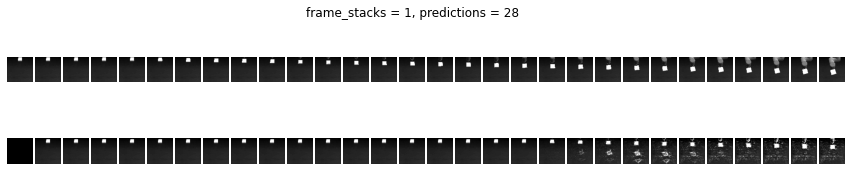

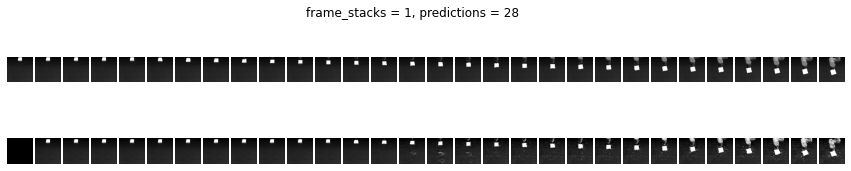

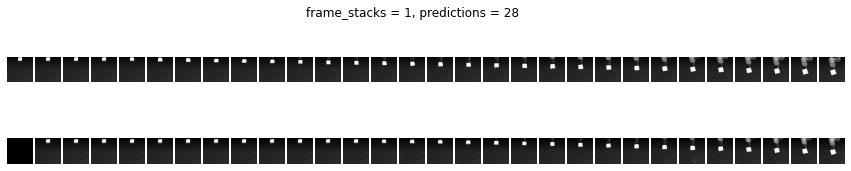

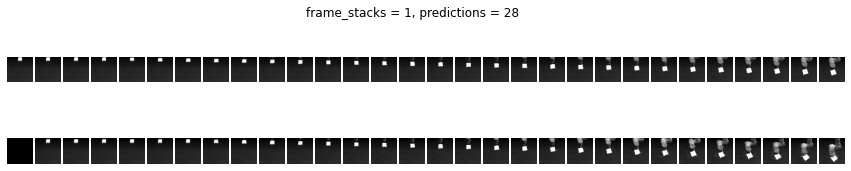

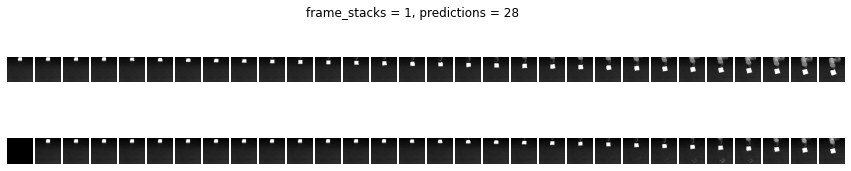

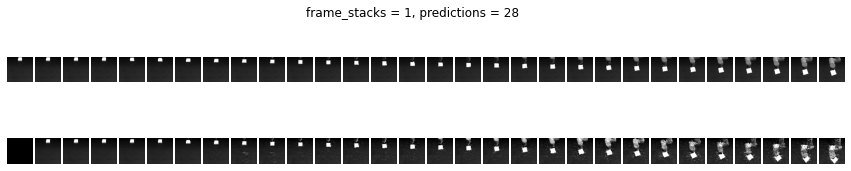

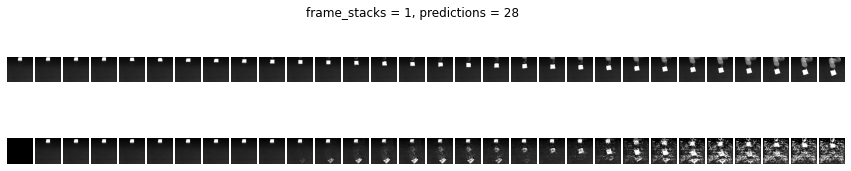

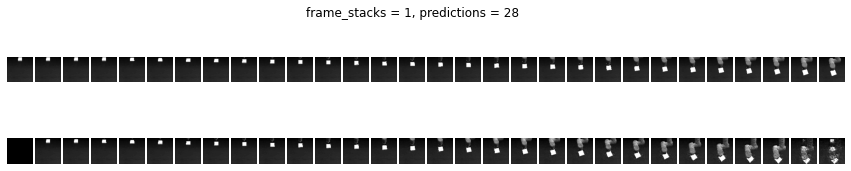

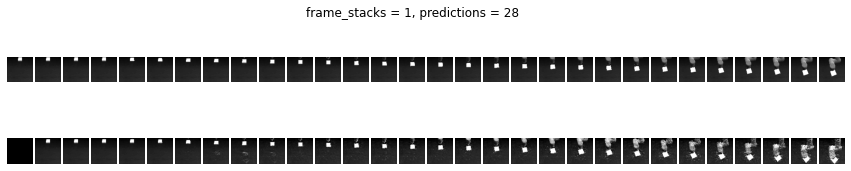

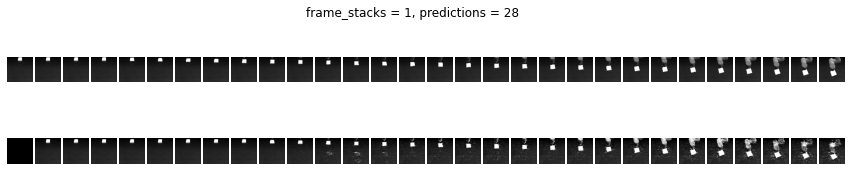

In [31]:
models = {}

# Load hyperparameters from trained model
for filedir in os.listdir(args.models_dir):
    fullpath = os.path.join(args.models_dir, filedir)
    if os.path.isdir(fullpath):
        models[fullpath] = {}
        with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
            models[fullpath]['hyperparameters'] = Namespace(**json.load(fp))
            
with torch.no_grad():
    for path, model in models.items():
        model_args = model['hyperparameters']
        if model_args.dim_x[0] == 1:
            imgs = imgs_gray
        elif model_args.dim_x[0] == 3:
            imgs = imgs_rgb
        
        enc, dec, dyn = load_models(path, model_args, mode='eval', device=args.device)
        T = model_args.frame_stacks
        
        ii = np.random.randint(imgs.shape[0] // args.n_examples)

        # Roll-out or predictions
        z_hat = torch.zeros((args.n_examples, (1 + args.n_predictions), model_args.dim_z)).to(device=args.device)
        u_f = actions[args.n_examples*ii:args.n_examples*(ii+1), 
                      (T + 1):(T + 1 + args.n_predictions)] # [u_T, ..., u_{T+args.n_predictions}]
        x = imgs[args.n_examples*ii:args.n_examples*(ii+1), 
                 :(T + 1 + args.n_predictions)]
        x_i = imgs[args.n_examples*ii:args.n_examples*(ii+1), 
                   :(T + 1)] # each [x0, ..., x_{T + 1}], torch.Size([args.n_examples, T, res, res])
        x_i_s = frame_stack(x_i, frames=T)  
        z_i, mu_z_i, logvar_z_i = enc(x_i_s.reshape(-1, *x_i_s.shape[2:]))
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None
        
        z_hat[:, 0] = z_i
        for jj in range(args.n_predictions):
            u_i = u_f[:, jj]
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = dyn(z_t=z_i, mu_t=mu_z_i, 
                                                    var_t=var_z_i, u=u_i, h=h_i, single=True)
            z_hat[:, jj + 1] = z_ip1[0]
            z_i, mu_z_i, var_z_i, h_i = z_ip1[0], mu_z_ip1[0], var_z_ip1[0], h_ip1    

        # Decode predictions
        x_hat = dec(z_hat.reshape(-1, *z_hat.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_predictions + 1), *x_hat.shape[1:])

        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_predictions
            rows = 2
            fig=plt.figure(figsize=(15, 3))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_predictions))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            plt.subplots_adjust(wspace=0.1, hspace=0)
            plt.show()